In [1]:
%load_ext autoreload
%autoreload 2

import os.path

import scanpy as sc
import seaborn as sns
import scanpy.external as sce
from flecs.utils import set_seed, get_project_root
import random
import numpy as np
from flecs.sc.utils import adapt_source_population_size, compute_dpt_quantile_paths, \
    compute_pseudotime_quantiles, compute_cell_knn_paths
import matplotlib.pyplot as plt
import scipy
import ot
import pandas as pd
from scvelo import tl

default_figsize = plt.rcParams["figure.figsize"]
set_seed(0)

In [2]:
use_magic = True
normalize_per_cell = True
normalize_gene_std = False
use_log1p = False

## Load

In [3]:
adata = sc.read_h5ad(os.path.join(get_project_root(), 
                                  "datasets", "Paul15", "processed", "paul15_with_mouse_grn.h5ad")
                    )
# Restrict to relevant cell populations
adata = adata[adata.obs["Batch_desc"].apply(lambda n: n in ['Unsorted myeloid',
                                                            'CMP Flt3+ Csf1r+', 
                                                            'Cebpe KO', 
                                                            'Cebpa KO'])].copy()

In [4]:
adata.layers["counts"] = adata.X

## Highly variable genes

In [5]:
sc.pp.filter_genes(adata, min_counts=1)
if normalize_per_cell:
    sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# Find highly variable genes
if not use_log1p:
    adata_copy = sc.pp.log1p(adata, copy=True)
    sc.pp.highly_variable_genes(adata_copy, n_top_genes=4000, flavor='cell_ranger')  # Expects logged data

    adata.var['highly_variable'] = adata_copy.var['highly_variable']
else:
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=4000, flavor='cell_ranger')

In [6]:
adata.var['highly_variable']["Cebpa"]

True

In [7]:
adata.var['highly_variable']["Cebpe"]

True

In [8]:
adata.var['highly_variable'].sum()

4000

In [9]:
if use_magic:
    sce.pp.magic(adata, t=3, n_pca=300, verbose=True)

Calculating MAGIC...
  Running MAGIC on 7296 cells and 11757 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 4.33 seconds.
    Calculating KNN search...
    Calculated KNN search in 21.88 seconds.
    Calculating affinities...
    Calculated affinities in 20.52 seconds.
  Calculated graph and diffusion operator in 46.75 seconds.
  Running MAGIC with `solver='exact'` on 11757-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 22.27 seconds.
Calculated MAGIC in 69.15 seconds.


In [10]:
adata = adata[:, adata.var['highly_variable']].copy()
# Renormalize after filtering
if normalize_per_cell:
    sc.pp.normalize_per_cell(adata)
if normalize_gene_std:
    adata.X /= adata.X.std(axis=0)
    
adata.obs.reset_index(inplace=True)

In [11]:
if use_magic:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=100, n_pcs=200)
    sc.tl.umap(adata, min_dist=0.3)
else:
    sc.tl.pca(adata, svd_solver="arpack", n_comps=200)
    sc.pp.neighbors(adata, n_neighbors=7, n_pcs=50)
    sc.tl.umap(adata, min_dist=0.3)

## Plots for dataset exploration

In [13]:
def plot_cell_type_distribution(adata, cell_type, root_cell=None, c="green"):
    assert c in ["green", "grey", "orange", "purple"]
    
    coords = adata[adata.obs["Batch_desc"] == cell_type].obsm['X_umap']

    if c == "green":
        plt.scatter(coords[:, 0], coords[:, 1], c="limegreen", alpha=0.9)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greens")
    if c == "orange":
        plt.scatter(coords[:, 0], coords[:, 1], c="orange", alpha=0.2)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Oranges")
    if c == "purple":
        plt.scatter(coords[:, 0], coords[:, 1], c="purple", alpha=0.2)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Purples")
    else:
        plt.scatter(coords[:, 0], coords[:, 1], c="k", alpha=0.05)
        sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greys")

    if root_cell is not None:
        root_cell_coord = adata.obsm["X_umap"][root_cell]
        plt.scatter(root_cell_coord[0], root_cell_coord[1], marker='*', s=300, zorder=2, c="r")

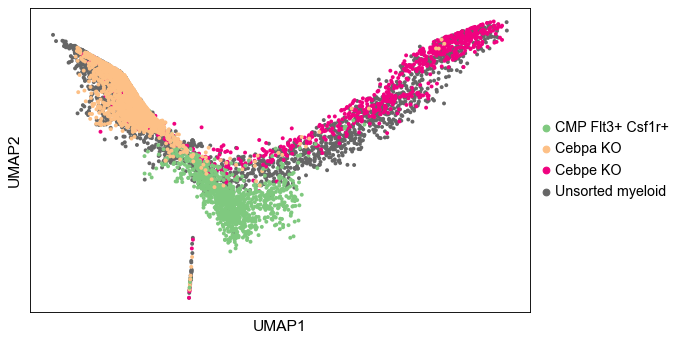

In [15]:
sc.set_figure_params(figsize=(8, 5))
sc.pl.umap(adata, color="Batch_desc", palette="Accent", 
        #    legend_loc='lower right', 
           size=50, title="")
sc.set_figure_params(figsize=default_figsize)

## Explore specific genes

In [74]:
adata

AnnData object with n_obs × n_vars = 7296 × 4000
    obs: 'index', 'Seq_batch_ID', 'Amp_batch_ID', 'well_coordinates', 'Mouse_ID', 'Plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'RMT_sequence', 'Number_of_cells', 'CD34_measurement', 'FcgR3_measurement', 'n_counts_all', 'n_counts'
    var: 'n_counts', 'highly_variable'
    uns: 'pca', 'neighbors', 'umap', 'Batch_desc_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'
    varp: 'grn_adj_mat'

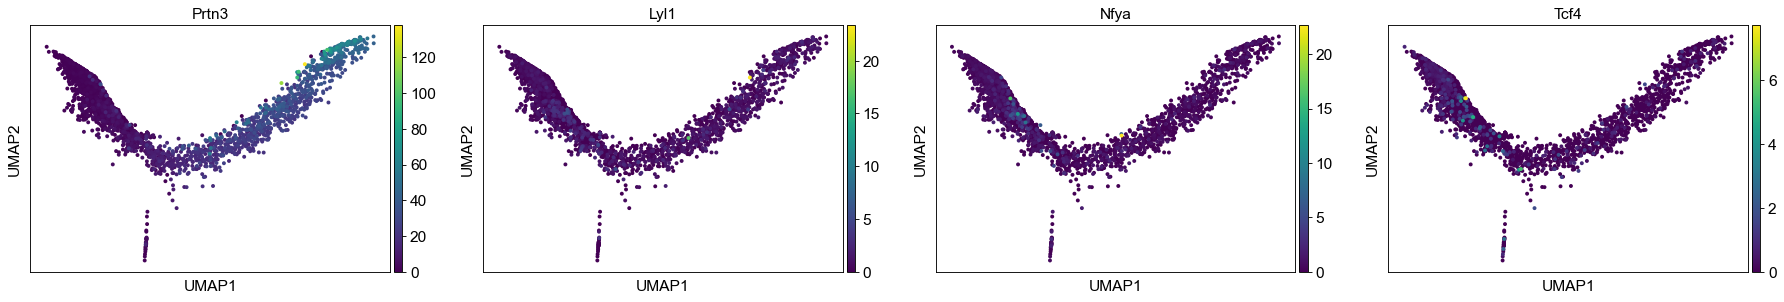

In [113]:
umap_gene = ["Prtn3", "Lyl1", "Nfya", "Tcf4"]
sc.set_figure_params(figsize=(6, 4))
adata_subset = adata[adata.obs["Batch_desc"] == "Unsorted myeloid"].copy()
fig = sc.pl.umap(adata_subset, color=umap_gene, palette="Accent", size=50,return_fig=True, title=umap_gene)


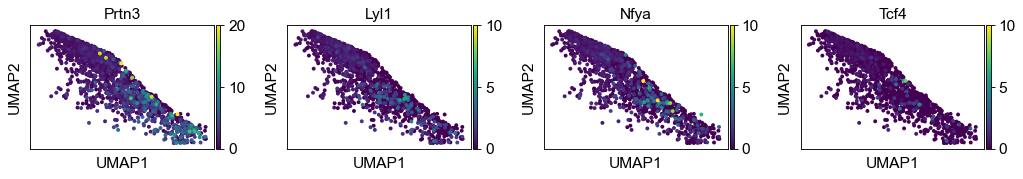

In [131]:
umap_gene = ["Prtn3", "Lyl1", "Nfya", "Tcf4"]
sc.set_figure_params(figsize=(3, 2))
adata_subset = adata[adata.obs["Batch_desc"] == "Unsorted myeloid"].copy()
adata_subset = adata_subset[np.apply_along_axis(lambda x: x[0] > 0 and  x[0] < 3 and  x[1] > 5 and  x[1] < 9, 1, adata_subset.obsm["X_umap"])].copy()

fig = sc.pl.umap(adata_subset, color=umap_gene, palette="Accent", size=50,return_fig=True, title=umap_gene,
                 vmax=[20, 10, 10, 10],
                 )

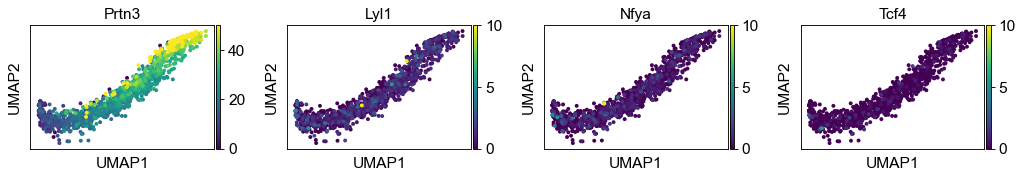

In [130]:
umap_gene = ["Prtn3", "Lyl1", "Nfya", "Tcf4"]
sc.set_figure_params(figsize=(3, 2))
adata_subset = adata[adata.obs["Batch_desc"] == "Unsorted myeloid"].copy()
adata_subset = adata_subset[np.apply_along_axis(lambda x: x[0] > 3 and  x[1] > 3 and  x[1] < 13, 1, adata_subset.obsm["X_umap"])].copy()

fig = sc.pl.umap(adata_subset, color=umap_gene, palette="Accent", size=50,return_fig=True, title=umap_gene,
                 vmax=[50, 10, 10, 10],
                 )

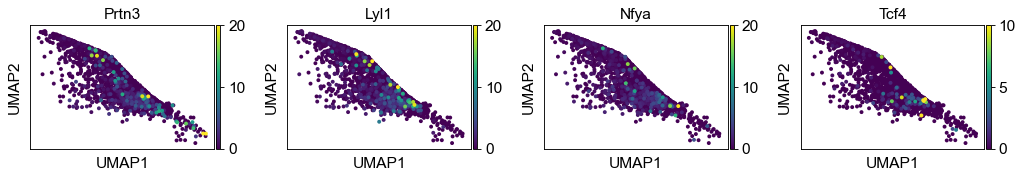

In [125]:
umap_gene = ["Prtn3", "Lyl1", "Nfya", "Tcf4"]
sc.set_figure_params(figsize=(3, 2))
adata_subset = adata[adata.obs["Batch_desc"] == "Cebpa KO"].copy()
adata_subset = adata_subset[np.apply_along_axis(lambda x: x[0] > 0 and  x[0] < 3 and  x[1] > 5 and  x[1] < 9, 1, adata_subset.obsm["X_umap"])].copy()

fig = sc.pl.umap(adata_subset, color=umap_gene, palette="Accent", size=50,return_fig=True, title=umap_gene, 
                 vmax=[20, 20, 20, 10],
                 )

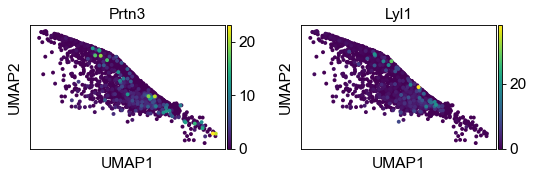

In [98]:
umap_gene = ["Prtn3", "Lyl1"]
sc.set_figure_params(figsize=(3, 2))
adata_subset = adata[adata.obs["Batch_desc"] == "Cebpa KO"].copy()
adata_subset = adata_subset[np.apply_along_axis(lambda x: x[0] > 0 and  x[0] < 3 and  x[1] > 5 and  x[1] < 9, 1, adata_subset.obsm["X_umap"])].copy()

fig = sc.pl.umap(adata_subset, color=umap_gene, palette="Accent", size=50,return_fig=True, title=umap_gene)

# for i in range(len(umap_gene)):
#     fig.axes[i].set_xlim(0, 3)
#     fig.axes[i].set_ylim(5, 9)

## Density plots

In [ ]:
sc.set_figure_params(figsize=default_figsize)

In [15]:
number_of_cells_df = pd.DataFrame(adata.obs["Batch_desc"].value_counts())
number_of_cells_df = number_of_cells_df.reset_index()
number_of_cells_df.columns = ["batch description", "Number of cells"]

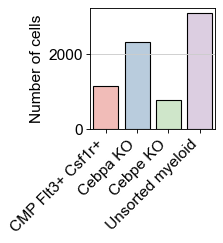

<Figure size 512x384 with 0 Axes>

In [62]:
plt.figure(figsize=(2,2))
plt.xticks(rotation=45, ha='right')
sns.barplot(data=number_of_cells_df, x="batch description", y="Number of cells", edgecolor = "black", palette="Pastel1")
plt.xlabel("")
plt.figure(figsize=default_figsize)
plt.show()

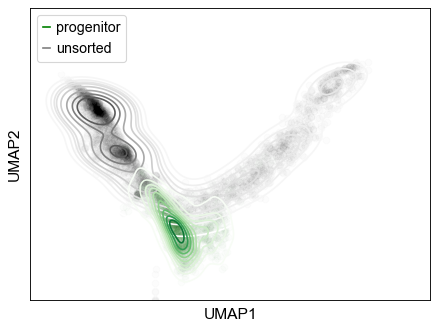

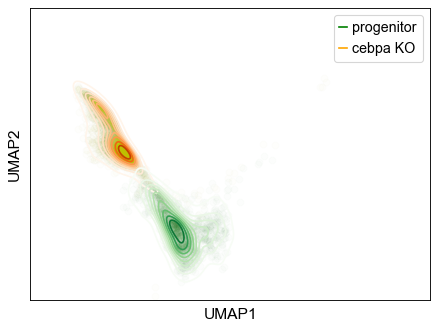

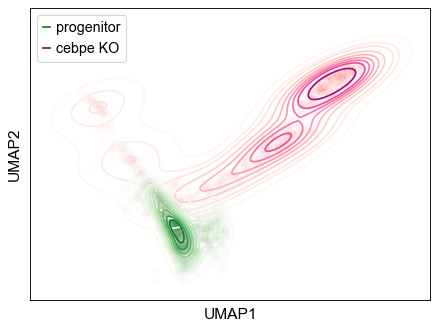

In [17]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

coords = adata[adata.obs["Batch_desc"] == 'Unsorted myeloid'].obsm['X_umap']
plt.scatter(coords[:, 0], coords[:, 1], c="k", alpha=0.01)
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greys")

coords = adata[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].obsm['X_umap']
plt.scatter(coords[:, 0], coords[:, 1], c="g", alpha=0.01)
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greens")
plt.xlim(-1, 12)
plt.ylim(1, 12)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

grey_legend = Line2D([0], [0], label='unsorted', color='grey')
green_legend = Line2D([0], [0], label='progenitor', color='green')
plt.legend(handles=[green_legend, grey_legend])

plt.show()

coords = adata[adata.obs["Batch_desc"] == 'Cebpa KO'].obsm['X_umap']
plt.scatter(coords[:, 0], coords[:, 1], c="y", alpha=0.01)
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Oranges")
coords = adata[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].obsm['X_umap']
plt.scatter(coords[:, 0], coords[:, 1], c="g", alpha=0.01)
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greens")
plt.xlim(-1, 12)
plt.ylim(1, 12)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

orange_legend = Line2D([0], [0], label='cebpa KO', color='orange')
green_legend = Line2D([0], [0], label='progenitor', color='green')
plt.legend(handles=[green_legend, orange_legend])

plt.show()

coords = adata[adata.obs["Batch_desc"] == 'Cebpe KO'].obsm['X_umap']
plt.scatter(coords[:, 0], coords[:, 1], c="r", alpha=0.01)
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="RdPu")
coords = adata[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].obsm['X_umap']
plt.scatter(coords[:, 0], coords[:, 1], c="g", alpha=0.01)
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greens")
plt.xlim(-1, 12)
plt.ylim(1, 12)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

purple_legend = Line2D([0], [0], label='cebpe KO', color='purple')
green_legend = Line2D([0], [0], label='progenitor', color='green')
plt.legend(handles=[green_legend, purple_legend])

plt.show()

## Compute root cells

In [18]:
def get_cell_indices(adata):
    # Get the indices of cells for the different populations
    cmp_cells = list(adata.obs[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].index.astype("int"))
    unsorted_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Unsorted myeloid'].index.astype("int"))
    cebpa_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpa KO'].index.astype("int"))
    cebpe_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpe KO'].index.astype("int"))

    return cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells

In [19]:
def set_root(_adata, targ_x, targ_y):
    plt.grid(b=None)
    plt.xticks([], [])
    plt.yticks([], [])
    _x, _y = _adata.obsm["X_umap"].T
    plt.scatter(_x, _y, s=10.)

    # Find root
    root_index = np.argmin((_adata.obsm['X_umap'][:, 0] - targ_x)**2 + (_adata.obsm['X_umap'][:, 1] - targ_y)**2)
    _adata.uns['iroot'] = root_index
    r_x, r_y = _adata[_adata.uns['iroot']].obsm["X_umap"].T

    # Plot target root as a cross
    plt.hlines(targ_y, xmin= targ_x - 0.5, xmax=targ_x + 0.5, color="r")
    plt.vlines(targ_x, ymin= targ_y - 0.5, ymax=targ_y + 0.5, color="r")

    # Plot actual root as a star
    plt.scatter(r_x, r_y, s=100., marker="*", c="r")

    return root_index


In [20]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
random.seed(0)
random.shuffle(cmp_cells)
random.shuffle(unsorted_cells)
random.shuffle(cebpa_cells)
random.shuffle(cebpe_cells)

In [21]:
obs_adata = adata[cmp_cells + unsorted_cells].copy()
cebpa_ko_adata = adata[cmp_cells + cebpa_cells].copy()
cebpe_ko_adata = adata[cmp_cells + cebpe_cells].copy()

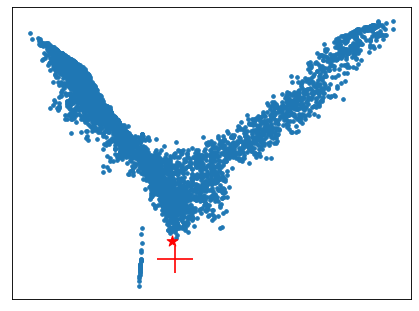

In [22]:
obs_root_index = set_root(obs_adata, 4, 1)

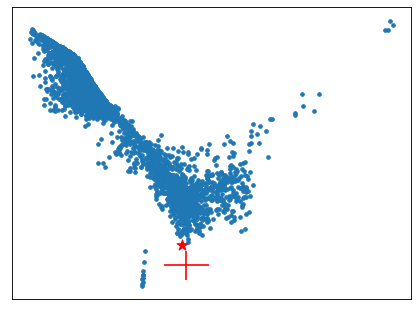

In [23]:
cebpa_root_index = set_root(cebpa_ko_adata, 4, 1)

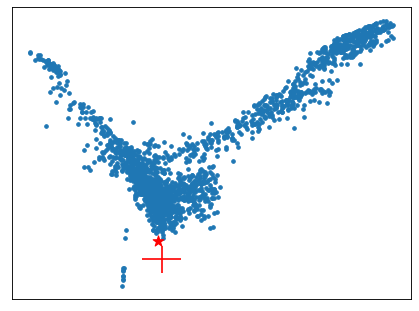

In [24]:
cebpe_root_index = set_root(cebpe_ko_adata, 4, 1)

## Utils

In [25]:
def plot_umap_quantile_paths(path_length):
    plt.figure(figsize=(12, 6))
    plt.grid(b=None)
    plt.xticks([], [])
    plt.yticks([], [])

    unsorted_shortest_paths = compute_dpt_quantile_paths(adata, cmp_cells, unsorted_cells, 
                                                             root_index=obs_root_index, n_bins=path_length)

    adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths

    plot_cell_type_distribution(adata, 'Unsorted myeloid', c="grey")
    plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")

    for i, path in enumerate(unsorted_shortest_paths.values()):
        if i % 10 == 0:
            path_coord = adata.obsm["X_umap"][path]
            plt.plot(path_coord[:, 0], path_coord[:, 1], c="k")
            
    plt.title("Quantile Umap with path " + str(path_length))
    plt.show()
    plt.figure(figsize=default_figsize)

In [26]:
def plot_pca_quantile_paths(n_pca, path_length=3):
    plt.figure(figsize=(12, 6))
    plt.grid(b=None)
    plt.xticks([], [])
    plt.yticks([], [])

    unsorted_shortest_paths = compute_dpt_quantile_paths(adata, cmp_cells, unsorted_cells, 
                                                             root_index=obs_root_index, n_bins=path_length,
                                                            option="PCA", n_pca=n_pca)

    adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths

    plot_cell_type_distribution(adata, 'Unsorted myeloid', c="grey")
    plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")

    for i, path in enumerate(unsorted_shortest_paths.values()):
        if i % 10 == 0:
            path_coord = adata.obsm["X_umap"][path]
            plt.plot(path_coord[:, 0], path_coord[:, 1], c="k")

    plt.title("Quantile PCA with " + str(path_length) + " paths and n_pca=" + str(n_pca))
    plt.show()
    plt.figure(figsize=default_figsize)

In [27]:
def plot_knn_paths(path_length, option="Umap", n_pca=None, plot_title=True, plot_figsize=(12, 6)):
    
    plt.figure(figsize=plot_figsize)
    plt.grid(b=None)
    plt.xticks([], [])
    plt.yticks([], [])

    unsorted_shortest_paths = compute_cell_knn_paths(adata, cmp_cells, unsorted_cells, n_bins=path_length,
                                                     option=option, n_pca=n_pca)

    adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths
    
    plot_cell_type_distribution(adata, 'Unsorted myeloid', c="grey")
    plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")


    for i, path in enumerate(unsorted_shortest_paths.values()):
        if i % 200 == 1:
            path_coord = adata.obsm["X_umap"][path]

            MAP = 'RdYlGn_r'
            NPOINTS = len(path_coord)

            cm = plt.get_cmap(MAP)

            for i in range(NPOINTS-1):
                plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)), linewidth=5)

            plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="g")
            plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

    if plot_title:
        plt.title("KNN " + option + " with " + str(path_length) + " paths and n_pca=" + str(n_pca))
    plt.show()
    
#     plt.hist([len(v) for v in adata.uns["unsorted_shortest_paths"].values()], bins=100)
#     plt.show()
    
    plt.figure(figsize=default_figsize)

In [28]:
def get_velocity_statistics(_adata, method, option, path_length, n_pca=None):
    
    _adata = _adata.copy()

    _adata.layers["velocity"] = np.zeros(_adata.shape)
    _adata.obs["velocity_length_umap_space"] = np.zeros((len(_adata), 1))
    _adata.layers["Ms"] = _adata.X

    for v in _adata.uns["unsorted_shortest_paths"].values():
        for i in range(len(v) - 1):
            _adata.layers["velocity"][v[i]] = _adata.X[v[i+1]] - _adata.X[v[i]]
            
            _adata.obs["velocity_length_umap_space"][v[i]] = \
                np.linalg.norm(_adata.obsm["X_umap"][v[i+1]] - _adata.obsm["X_umap"][v[i]])

    # Only consider cells that belong to a path to compute statistics
    nonzero_velo_adata = _adata[np.any(_adata.layers["velocity"], axis=1)]
    
    sc.pp.neighbors(nonzero_velo_adata)
    tl.velocity_graph(nonzero_velo_adata, vkey="velocity", n_jobs=8)
    tl.velocity_confidence(nonzero_velo_adata, vkey="velocity")

    # Put results in a dataframe
    velocity_df = nonzero_velo_adata.obs[["velocity_length", 
                                        "velocity_confidence", 
                                        "velocity_length_umap_space"]]
    velocity_df["method"] = method
    velocity_df["option"] = option
    velocity_df["path_length"] = path_length
    velocity_df["n_pca"] = n_pca
    velocity_df.reset_index(inplace=True, drop=True)
    
    # We also consider the smoothness of the path
    _adata.obsm["smoothness_gene_space"] = np.zeros((len(_adata), 1))
    _adata.obsm["smoothness_umap_space"] = np.zeros((len(_adata), 1))
    
    for v in _adata.uns["unsorted_shortest_paths"].values():
        for i in range(len(v) - 2):
            # In gene space
            velo_g_prev = _adata.X[v[i+1]] - _adata.X[v[i]]
            velo_g_curr = _adata.X[v[i+2]] - _adata.X[v[i+1]]
            
            velo_g_prev /= np.linalg.norm(velo_g_prev)
            velo_g_curr /= np.linalg.norm(velo_g_curr)
            
            # In umap space
            velo_u_prev = _adata.obsm["X_umap"][v[i+1]] - _adata.obsm["X_umap"][v[i]]
            velo_u_curr = _adata.obsm["X_umap"][v[i+2]] - _adata.obsm["X_umap"][v[i+1]]
            
            velo_u_prev /= np.linalg.norm(velo_u_prev)
            velo_u_curr /= np.linalg.norm(velo_u_curr)

            _adata.obsm["smoothness_gene_space"][v[i+1]] = np.linalg.norm(velo_g_curr - velo_g_prev)
            _adata.obsm["smoothness_umap_space"][v[i+1]] = np.linalg.norm(velo_u_curr - velo_u_prev)
            
    # Only consider cells for which we have an estimate of the smoothness
    nonzero_smooth_adata = _adata[np.any(_adata.obsm["smoothness_gene_space"], axis=1)]
    
    smoothness_df = pd.DataFrame(np.concatenate((nonzero_smooth_adata.obsm["smoothness_gene_space"],
                                                 nonzero_smooth_adata.obsm["smoothness_umap_space"]),
                                                axis=1),
                                 columns=["smoothness_gene_space", "smoothness_umap_space"])
    
    smoothness_df["method"] = method
    smoothness_df["option"] = option
    smoothness_df["path_length"] = path_length
    smoothness_df["n_pca"] = n_pca
    smoothness_df.reset_index(inplace=True, drop=True)
    
    return velocity_df, smoothness_df

## Trajectory extraction method evaluation

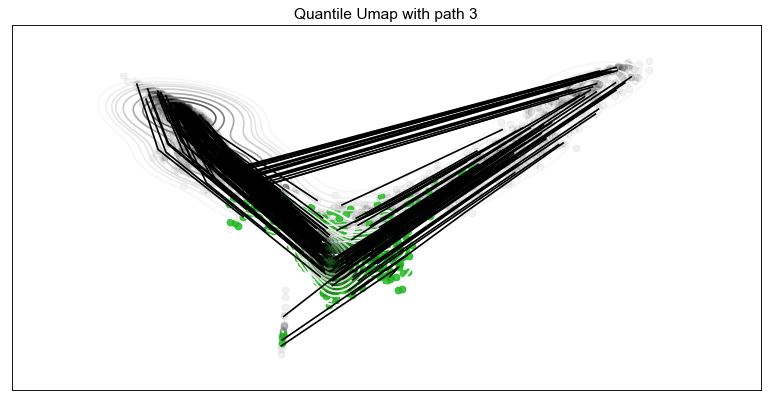

computing velocity graph (using 8/8 cores)


  0%|          | 0/2816 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

In [29]:
plot_umap_quantile_paths(3)
velocity_df, smoothness_df = get_velocity_statistics(adata, method="quantile", option="umap", path_length=3)

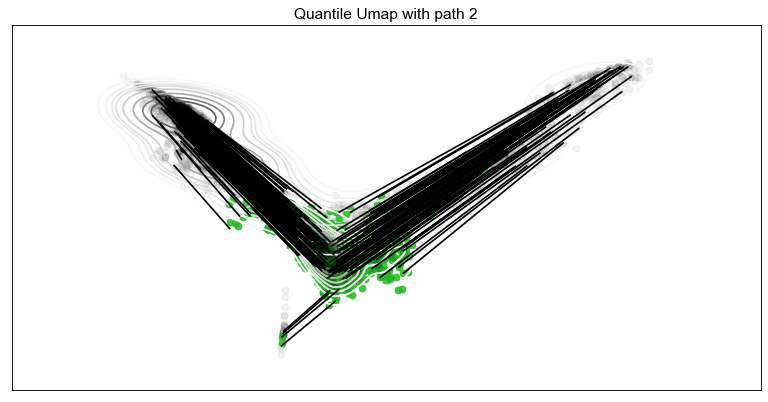

computing velocity graph (using 8/8 cores)


  0%|          | 0/2112 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

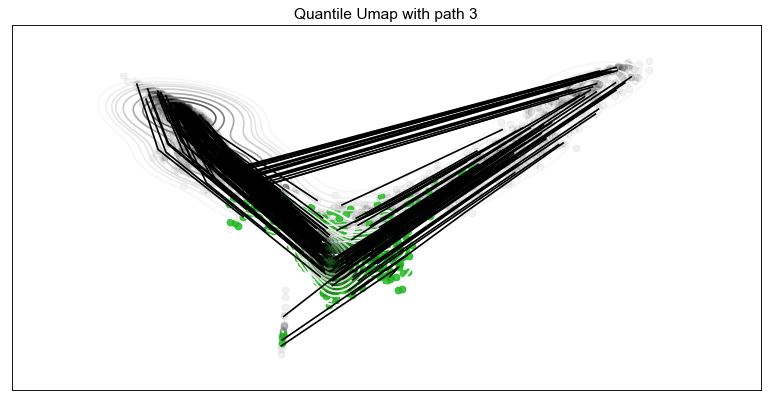

computing velocity graph (using 8/8 cores)


  0%|          | 0/2816 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

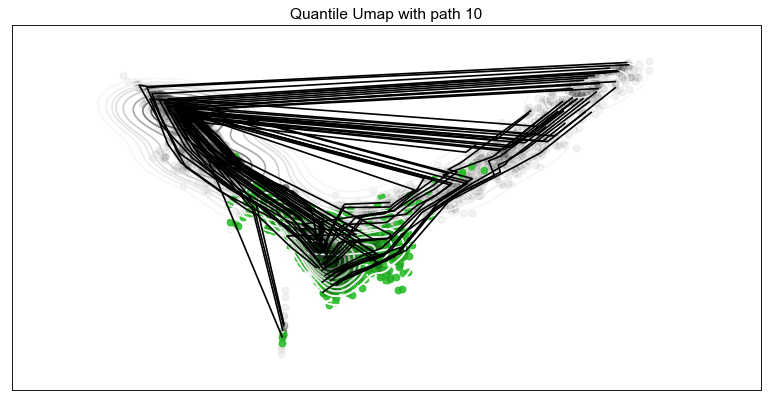

computing velocity graph (using 8/8 cores)


  0%|          | 0/3798 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

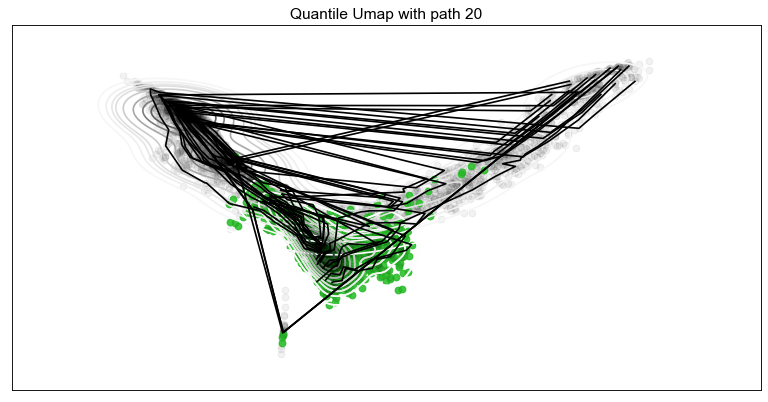

computing velocity graph (using 8/8 cores)


  0%|          | 0/4009 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

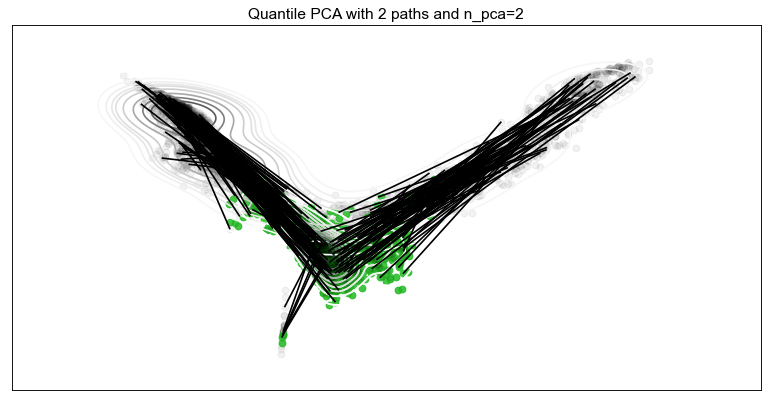

computing velocity graph (using 8/8 cores)


  0%|          | 0/2112 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

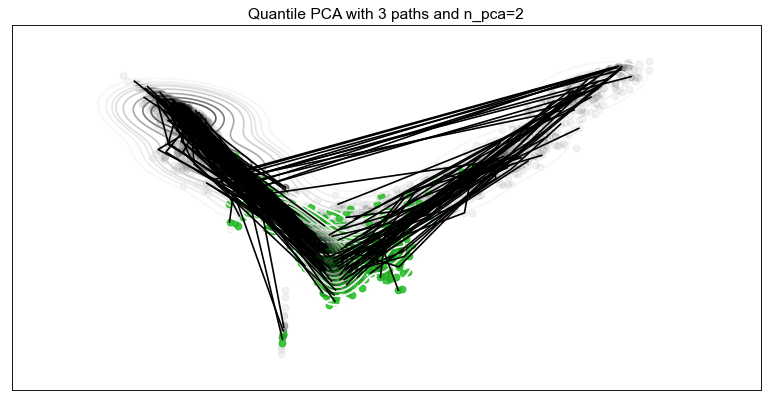

computing velocity graph (using 8/8 cores)


  0%|          | 0/2816 [00:00<?, ?cells/s]

    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

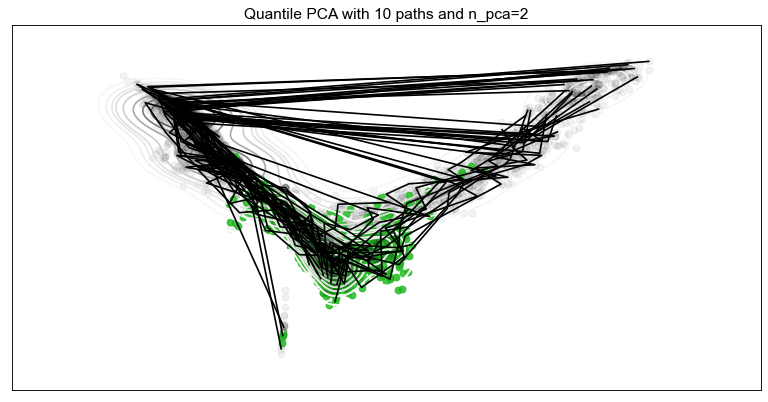

computing velocity graph (using 8/8 cores)


  0%|          | 0/3798 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

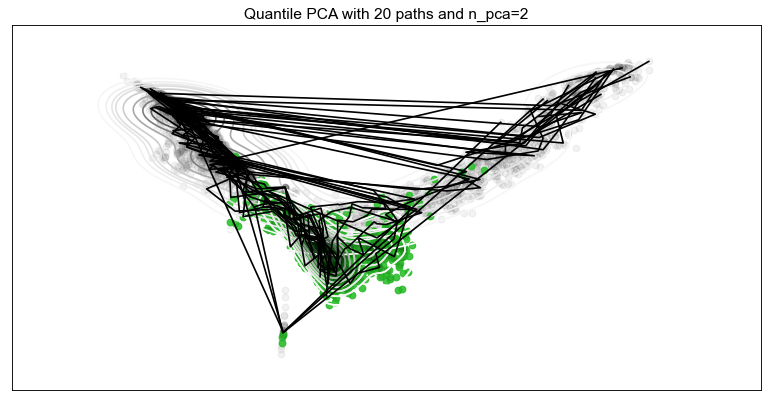

computing velocity graph (using 8/8 cores)


  0%|          | 0/4009 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:22<00:00, 21.60it/s]


<Figure size 512x384 with 0 Axes>

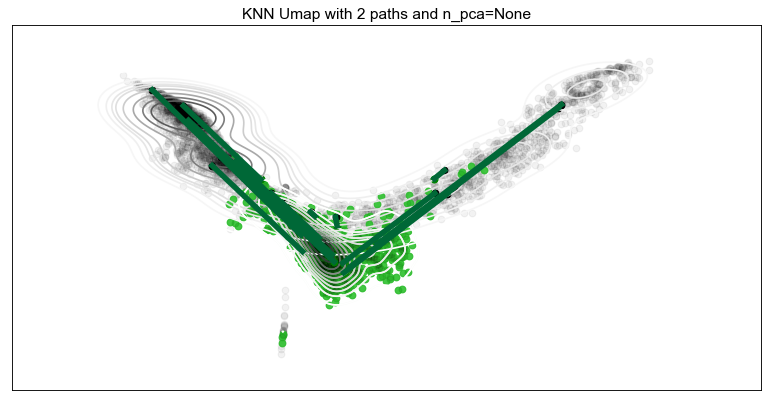

computing velocity graph (using 8/8 cores)


  0%|          | 0/1152 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:22<00:00, 21.57it/s]


<Figure size 512x384 with 0 Axes>

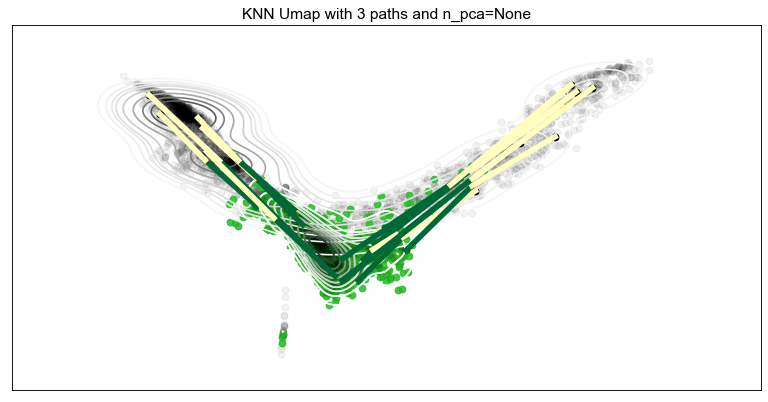

computing velocity graph (using 8/8 cores)


  0%|          | 0/1459 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:26<00:00, 21.04it/s]


<Figure size 512x384 with 0 Axes>

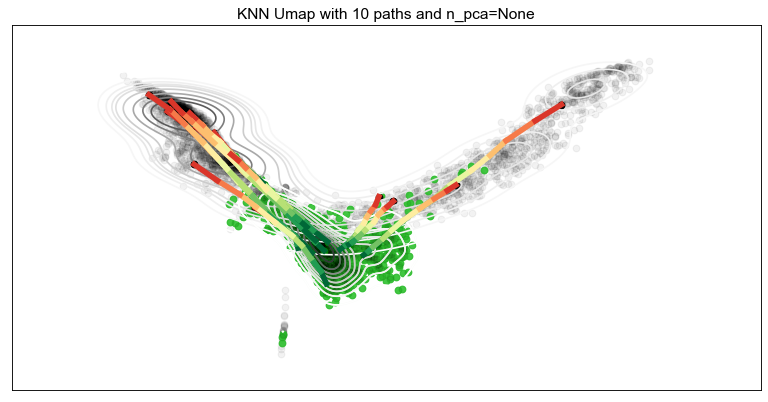

computing velocity graph (using 8/8 cores)


  0%|          | 0/1935 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:33<00:00, 20.06it/s]


<Figure size 512x384 with 0 Axes>

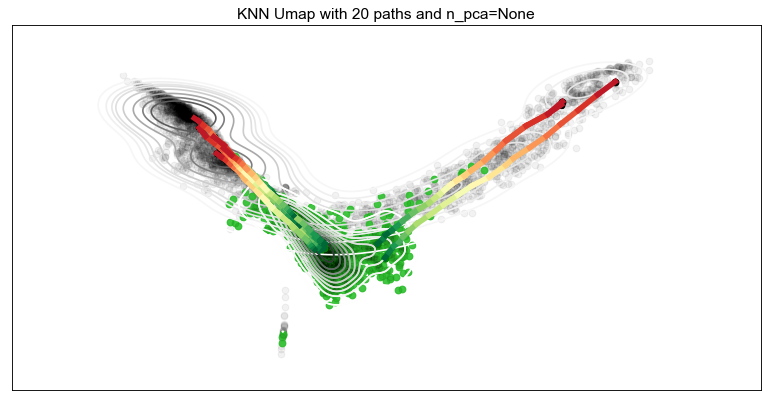

computing velocity graph (using 8/8 cores)


  0%|          | 0/2002 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:10<00:00, 23.61it/s]


<Figure size 512x384 with 0 Axes>

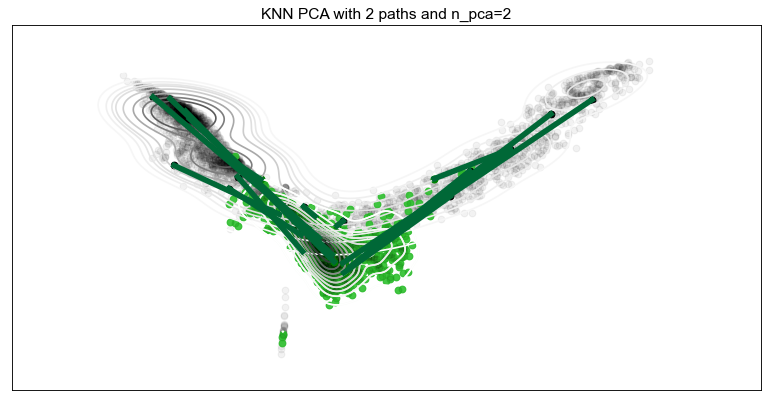

computing velocity graph (using 8/8 cores)


  0%|          | 0/1152 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:16<00:00, 22.49it/s]


<Figure size 512x384 with 0 Axes>

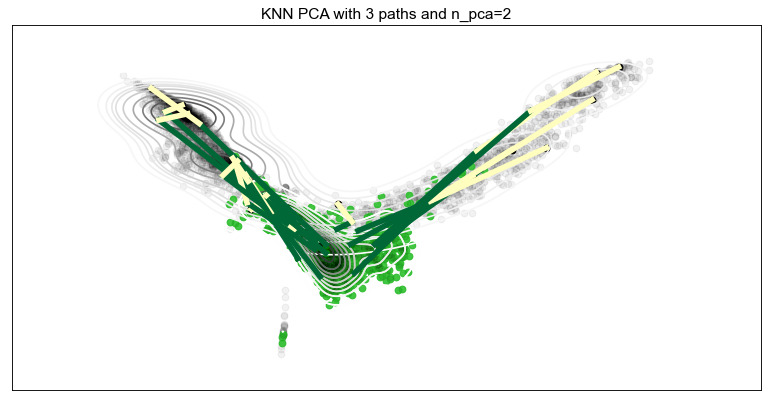

computing velocity graph (using 8/8 cores)


  0%|          | 0/1463 [00:00<?, ?cells/s]

    finished (0:00:04) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:10<00:00, 23.56it/s]


<Figure size 512x384 with 0 Axes>

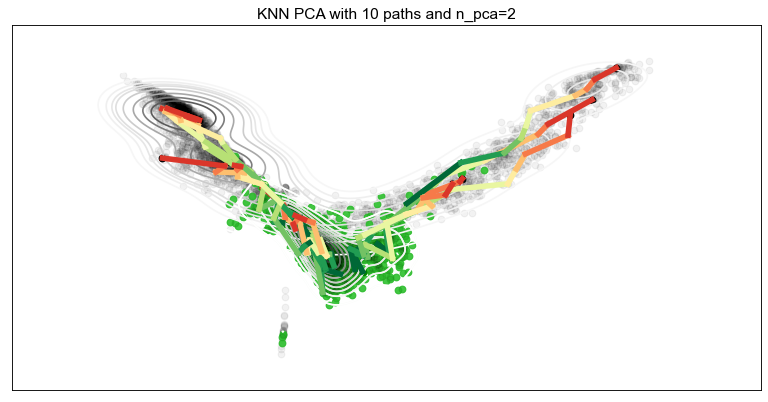

computing velocity graph (using 8/8 cores)


  0%|          | 0/1926 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


100%|██████████| 3072/3072 [02:16<00:00, 22.43it/s]


<Figure size 512x384 with 0 Axes>

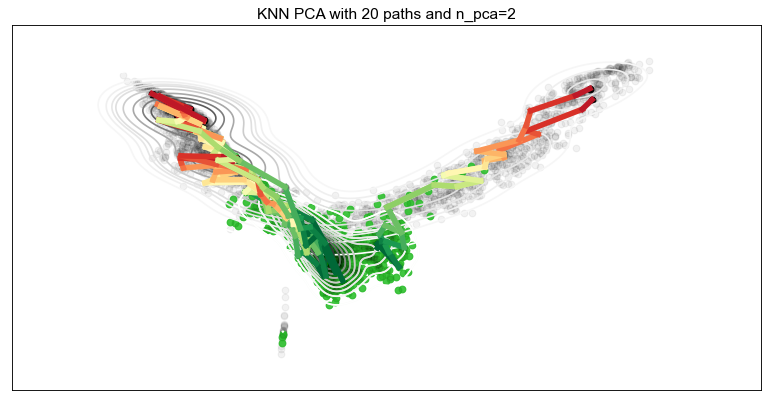

computing velocity graph (using 8/8 cores)


  0%|          | 0/1851 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


<Figure size 512x384 with 0 Axes>

In [30]:
all_velocity_df, all_smoothness_df = [], []

# Quantile based with Umap, vary path length
for path_length in [2, 3, 10, 20]:
    plot_umap_quantile_paths(path_length)
    velocity_df, smoothness_df = get_velocity_statistics(adata, method="quantile", 
                                                         option="umap", path_length=path_length)
    
    all_velocity_df.append(velocity_df)
    all_smoothness_df.append(smoothness_df)
    
# Quantile based with 2D PCA, vary path length
for path_length in [2, 3, 10, 20]:
    plot_pca_quantile_paths(n_pca=2, path_length=path_length)
    velocity_df, smoothness_df = get_velocity_statistics(adata, method="quantile", 
                                                         option="pca", n_pca=2, path_length=path_length)
    
    all_velocity_df.append(velocity_df)
    all_smoothness_df.append(smoothness_df)
    
# KNN based with Umap, vary path length
for path_length in [2, 3, 10, 20]:
    plot_knn_paths(path_length=path_length, option="Umap")
    velocity_df, smoothness_df = get_velocity_statistics(adata, method="knn", 
                                                         option="umap", n_pca=None, path_length=path_length)
    
    all_velocity_df.append(velocity_df)
    all_smoothness_df.append(smoothness_df)
    
# KNN based with PCA, vary path length
for path_length in [2, 3, 10, 20]:
    plot_knn_paths(path_length=path_length, option="PCA", n_pca=2)
    velocity_df, smoothness_df = get_velocity_statistics(adata, method="knn", 
                                                         option="pca", n_pca=2, path_length=path_length)
    
    all_velocity_df.append(velocity_df)
    all_smoothness_df.append(smoothness_df)

velocity_df = pd.concat(all_velocity_df)
smoothness_df = pd.concat(all_smoothness_df)

## Trajectory plots

In [119]:
unsorted_shortest_paths = compute_cell_knn_paths(adata, cmp_cells, unsorted_cells, n_bins=path_length, option="Umap", n_pca=None)

adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths

100%|██████████| 3072/3072 [03:00<00:00, 17.00it/s]


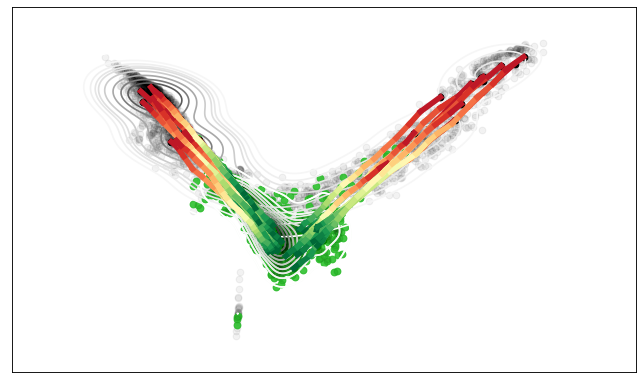

In [122]:
plt.figure(figsize=(10, 6))
plt.grid(b=None)
plt.xticks([], [])
plt.yticks([], [])

plot_cell_type_distribution(adata, 'Unsorted myeloid', c="grey")
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")

for i, path in enumerate(unsorted_shortest_paths.values()):
    if i % 50 == 1:
        path_coord = adata.obsm["X_umap"][path]

        MAP = 'RdYlGn_r'
        NPOINTS = len(path_coord)

        cm = plt.get_cmap(MAP)

        for i in range(NPOINTS-1):
            plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)), linewidth=5)

        plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="g")
        plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()


In [124]:
unsorted_shortest_paths_quantile = compute_dpt_quantile_paths(adata, cmp_cells, unsorted_cells, 
                                                             root_index=obs_root_index, n_bins=path_length)

adata.uns["unsorted_shortest_paths_quantile"] = unsorted_shortest_paths_quantile

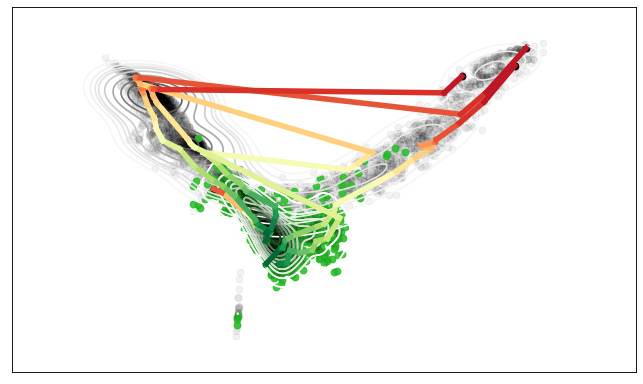

In [127]:
plt.figure(figsize=(10, 6))
plt.grid(b=None)
plt.xticks([], [])
plt.yticks([], [])

plot_cell_type_distribution(adata, 'Unsorted myeloid', c="grey")
plot_cell_type_distribution(adata, 'CMP Flt3+ Csf1r+', c="green")

for i, path in enumerate(unsorted_shortest_paths_quantile.values()):
    if i % 50 == 0:
        path_coord = adata.obsm["X_umap"][path]

        MAP = 'RdYlGn_r'
        NPOINTS = len(path_coord)

        cm = plt.get_cmap(MAP)

        for i in range(NPOINTS-1):
            plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.0*i/(NPOINTS-1)), linewidth=5)

        plt.scatter(path_coord[0, 0], path_coord[0, 1], marker="o", c="g")
        plt.scatter(path_coord[-1, 0], path_coord[-1, 1], marker="o", c="k")

plt.show()


## Save

In [51]:
velocity_df.to_pickle("velocity_df.pkl")

In [52]:
smoothness_df.to_pickle("smoothness_df.pkl")

In [3]:
velocity_df = pd.read_pickle("logs/velocity_df.pkl")
smoothness_df = pd.read_pickle("logs/smoothness_df.pkl")

In [4]:
velocity_df

velocity_length  velocity_confidence  velocity_length_umap_space  \
0               11.23             0.665715                    2.284617   
1               20.06             0.625419                    2.190092   
2               19.28             0.924680                    2.453950   
3               36.48             0.940229                    5.527541   
4               14.72             0.747268                    2.867868   
...               ...                  ...                         ...   
1846             4.16             0.522363                    0.413700   
1847             4.86             0.226975                    0.607808   
1848             3.14             0.281797                    1.055536   
1849             2.21             0.183576                    0.895961   
1850             4.20             0.223395                    1.197428   

        method option  path_length n_pca  
0     quantile   umap            2  None  
1     quantile   umap            2  None  
2     quantile   umap            2  None  
3     quantile   umap            2  None  
4     quantile   umap            2  None  
...        ...    ...          ...   ...  
1846       knn    pca           20     2  
1847       knn    pca           20     2  
1848       knn    pca           20     2  
1849       knn    pca           20     2  
1850       knn    pca           20     2  

[38410 rows x 7 columns]

In [5]:
smoothness_df

smoothness_gene_space  smoothness_umap_space    method option  \
0                  1.197609               0.292781  quantile   umap   
1                  0.899470               0.015942  quantile   umap   
2                  1.020432               0.018205  quantile   umap   
3                  1.662997               1.506402  quantile   umap   
4                  1.256625               0.202855  quantile   umap   
...                     ...                    ...       ...    ...   
1312               1.737678               0.019012       knn    pca   
1313               1.743977               1.969719       knn    pca   
1314               1.651748               0.080382       knn    pca   
1315               1.400223               1.985658       knn    pca   
1316               1.536492               0.086964       knn    pca   

      path_length n_pca  
0               3  None  
1               3  None  
2               3  None  
3               3  None  
4               3  None  
...           ...   ...  
1312           20     2  
1313           20     2  
1314           20     2  
1315           20     2  
1316           20     2  

[23643 rows x 6 columns]

## Plots, comparison quantile v.s. KNN, when based on Umap

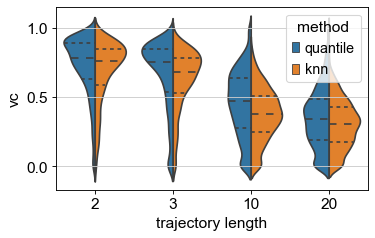

In [6]:
sc.set_figure_params(figsize=(5, 3))
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
sns.violinplot(subset_velocity_df, y="velocity_confidence", x="path_length", 
               hue="method", split=True, inner="quart")

plt.ylabel("vc")
plt.xlabel("trajectory length")
plt.show()

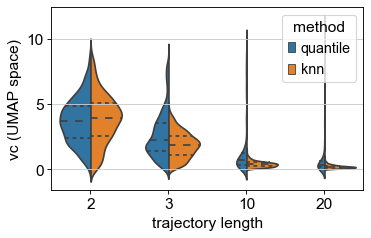

In [7]:
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
sns.violinplot(subset_velocity_df, y="velocity_length_umap_space", x="path_length", 
               hue="method", split=True, inner="quart")

plt.ylabel("vc (UMAP space)")
plt.xlabel("trajectory length")
plt.show()

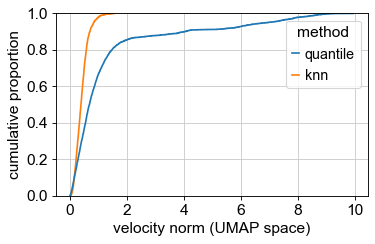

In [25]:
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
subset_velocity_df = subset_velocity_df[subset_velocity_df["path_length"] == 10]
ax = sns.ecdfplot(subset_velocity_df, x="velocity_length_umap_space", hue="method")
plt.xlabel("velocity norm (UMAP space)")
plt.ylabel("cumulative proportion")
plt.show()

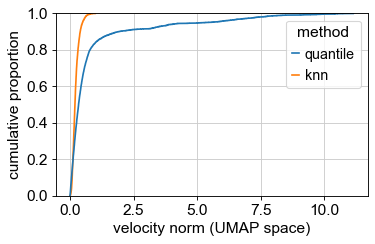

In [26]:
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
subset_velocity_df = subset_velocity_df[subset_velocity_df["path_length"] == 20]
ax = sns.ecdfplot(subset_velocity_df, x="velocity_length_umap_space", hue="method")
plt.xlabel("velocity norm (UMAP space)")
plt.ylabel("cumulative proportion")
plt.show()

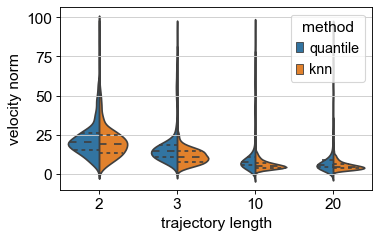

In [8]:
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
sns.violinplot(subset_velocity_df, y="velocity_length", x="path_length", 
               hue="method", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("velocity norm")
plt.show()

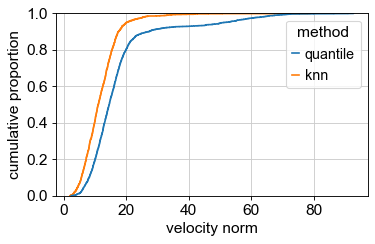

In [28]:
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
subset_velocity_df = subset_velocity_df[subset_velocity_df["path_length"] == 3]
ax = sns.ecdfplot(subset_velocity_df, x="velocity_length", hue="method")
plt.xlabel("velocity norm")
plt.ylabel("cumulative proportion")
plt.show()

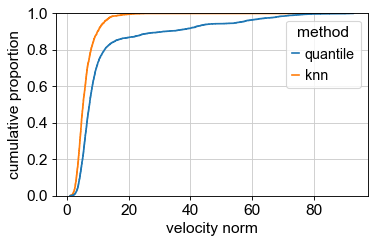

In [29]:
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
subset_velocity_df = subset_velocity_df[subset_velocity_df["path_length"] == 10]
ax = sns.ecdfplot(subset_velocity_df, x="velocity_length", hue="method")
plt.xlabel("velocity norm")
plt.ylabel("cumulative proportion")
plt.show()

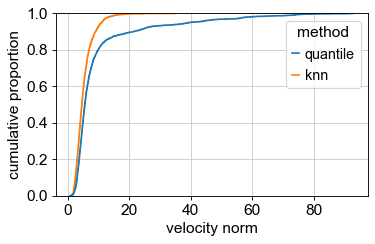

In [30]:
subset_velocity_df = velocity_df[velocity_df["option"] == "umap"]
subset_velocity_df = subset_velocity_df[subset_velocity_df["path_length"] == 20]
ax = sns.ecdfplot(subset_velocity_df, x="velocity_length", hue="method")
plt.xlabel("velocity norm")
plt.ylabel("cumulative proportion")
plt.show()

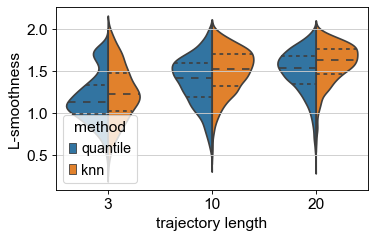

In [9]:
subset_smoothness_df = smoothness_df[smoothness_df["option"] == "umap"]
sns.violinplot(subset_smoothness_df, y="smoothness_gene_space", x="path_length", 
               hue="method", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("L-smoothness")
plt.show()

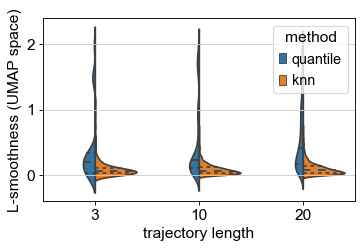

In [10]:
subset_smoothness_df = smoothness_df[smoothness_df["option"] == "umap"]
sns.violinplot(subset_smoothness_df, y="smoothness_umap_space", x="path_length", 
               hue="method", split=True, inner="quart")
# plt.ylim(0, 0.5)
plt.xlabel("trajectory length")
plt.ylabel("L-smoothness (UMAP space)")
plt.show()

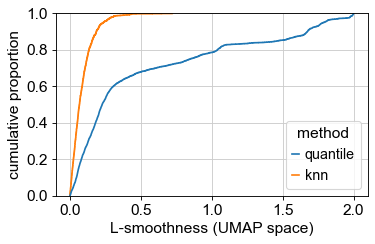

In [17]:
subset_smoothness_df = smoothness_df[smoothness_df["option"] == "umap"]
subset_smoothness_df = subset_smoothness_df[subset_smoothness_df["path_length"] == 10]
ax = sns.ecdfplot(subset_smoothness_df, x="smoothness_umap_space", hue="method")
plt.xlabel("L-smoothness (UMAP space)")
plt.ylabel("cumulative proportion")
plt.show()

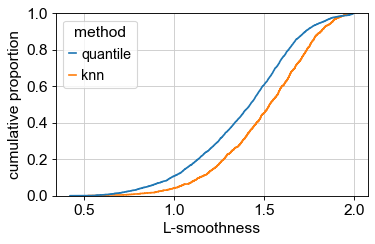

In [18]:
subset_smoothness_df = smoothness_df[smoothness_df["option"] == "umap"]
subset_smoothness_df = subset_smoothness_df[subset_smoothness_df["path_length"] == 10]
ax = sns.ecdfplot(subset_smoothness_df, x="smoothness_gene_space", hue="method")
plt.xlabel("L-smoothness")
plt.ylabel("cumulative proportion")
plt.show()

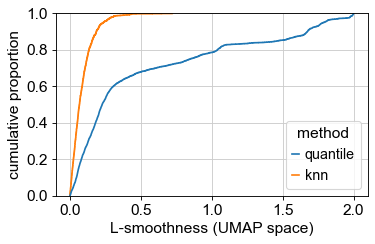

In [19]:
subset_smoothness_df = smoothness_df[smoothness_df["option"] == "umap"]
subset_smoothness_df = subset_smoothness_df[subset_smoothness_df["path_length"] == 10]
ax = sns.ecdfplot(subset_smoothness_df, x="smoothness_umap_space", hue="method")
plt.xlabel("L-smoothness (UMAP space)")
plt.ylabel("cumulative proportion")
plt.show()

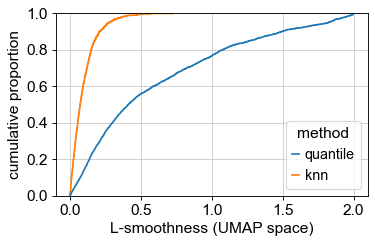

In [20]:
subset_smoothness_df = smoothness_df[smoothness_df["option"] == "umap"]
subset_smoothness_df = subset_smoothness_df[subset_smoothness_df["path_length"] == 20]
ax = sns.ecdfplot(subset_smoothness_df, x="smoothness_umap_space", hue="method")
plt.xlabel("L-smoothness (UMAP space)")
plt.ylabel("cumulative proportion")
plt.show()

## Effect of basing extraction on PCA, for quantiles

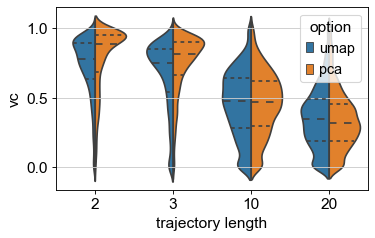

In [11]:
subset_velocity_df = velocity_df[velocity_df["method"] == "quantile"]
sns.violinplot(subset_velocity_df, y="velocity_confidence", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("vc")
plt.show()

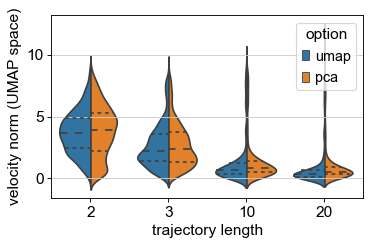

In [12]:
subset_velocity_df = velocity_df[velocity_df["method"] == "quantile"]
sns.violinplot(subset_velocity_df, y="velocity_length_umap_space", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("velocity norm (UMAP space)")
plt.show()

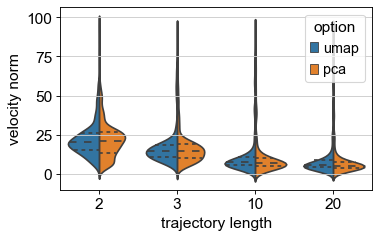

In [13]:
subset_velocity_df = velocity_df[velocity_df["method"] == "quantile"]
sns.violinplot(subset_velocity_df, y="velocity_length", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("velocity norm")
plt.show()

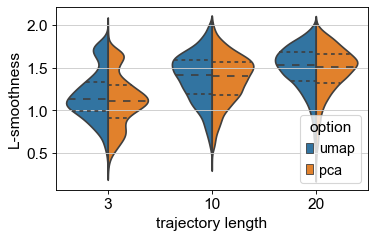

In [14]:
subset_smoothness_df = smoothness_df[smoothness_df["method"] == "quantile"]
sns.violinplot(subset_smoothness_df, y="smoothness_gene_space", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("L-smoothness")
plt.show()

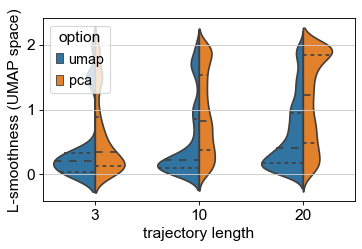

In [15]:
subset_smoothness_df = smoothness_df[smoothness_df["method"] == "quantile"]
sns.violinplot(subset_smoothness_df, y="smoothness_umap_space", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("L-smoothness (UMAP space)")
plt.show()

## Effect of basing extraction on PCA, for KNN

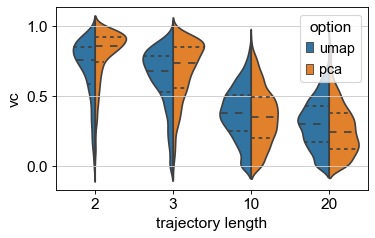

In [16]:
subset_velocity_df = velocity_df[velocity_df["method"] == "knn"]
sns.violinplot(subset_velocity_df, y="velocity_confidence", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("vc")
plt.show()

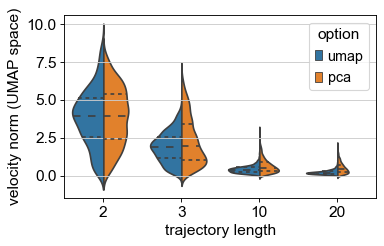

In [17]:
subset_velocity_df = velocity_df[velocity_df["method"] == "knn"]
sns.violinplot(subset_velocity_df, y="velocity_length_umap_space", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("velocity norm (UMAP space)")
plt.show()

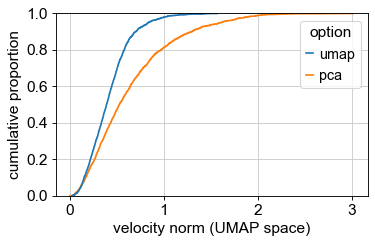

In [34]:
subset_velocity_df = velocity_df[velocity_df["method"] == "knn"]
subset_velocity_df = subset_velocity_df[subset_velocity_df["path_length"] == 10]
ax = sns.ecdfplot(subset_velocity_df, x="velocity_length_umap_space", hue="option")
plt.xlabel("velocity norm (UMAP space)")
plt.ylabel("cumulative proportion")
plt.show()

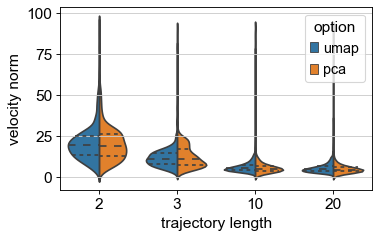

In [18]:
subset_velocity_df = velocity_df[velocity_df["method"] == "knn"]
sns.violinplot(subset_velocity_df, y="velocity_length", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("velocity norm")
plt.show()

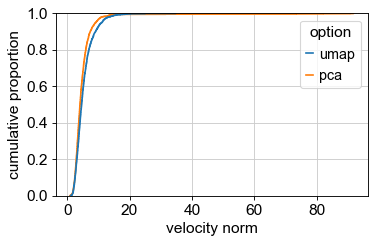

In [36]:
subset_velocity_df = velocity_df[velocity_df["method"] == "knn"]
subset_velocity_df = subset_velocity_df[subset_velocity_df["path_length"] == 20]
ax = sns.ecdfplot(subset_velocity_df, x="velocity_length", hue="option")
plt.xlabel("velocity norm")
plt.ylabel("cumulative proportion")
plt.show()

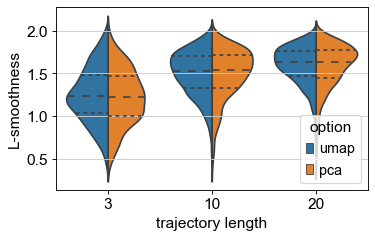

In [19]:
subset_smoothness_df = smoothness_df[smoothness_df["method"] == "knn"]
sns.violinplot(subset_smoothness_df, y="smoothness_gene_space", x="path_length", 
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("L-smoothness")
plt.show()

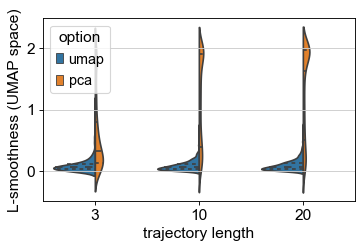

In [20]:
subset_smoothness_df = smoothness_df[smoothness_df["method"] == "knn"]
sns.violinplot(subset_smoothness_df, y="smoothness_umap_space", x="path_length",
               hue="option", split=True, inner="quart")
plt.xlabel("trajectory length")
plt.ylabel("L-smoothness (UMAP space)")
plt.show()